### Comparison between traditional AlphaShap and Modified AlphaShape

In [1]:
import open3d as o3d
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
matplotlib.rcParams['figure.dpi'] = 150
import copy
from scipy.spatial import Delaunay
from collections import defaultdict
import time

In [2]:
def plot_image(section, path = None, cmap_name = 'Greys', cv_map = None):
    matplotlib.rcParams['figure.dpi'] = 100
    x=np.arange(0,section.shape[1])
    y=np.arange(0,section.shape[0])
    X,Y=np.meshgrid(x,y)
    Z=section
    fig,ax = plt.subplots()
    cmap = plt.get_cmap(cmap_name)
    if cv_map is None:
        levels = MaxNLocator(nbins=100).tick_values(Z.min(),Z.max())
    else:
        levels = MaxNLocator(nbins=100).tick_values(cv_map[0],cv_map[1])
    norm = BoundaryNorm(levels, ncolors=cmap.N)
    ax.pcolormesh(X-0.5, Y-0.5, Z,shading='auto',cmap=cmap, norm=norm)
    ax.set_aspect('equal', 'box')
    if path is not None:
        for i in range(len(path)):
            ax.plot(path[i][0],path[i][1],color = 'r')
            for j in range(int(len(path[i][0])/2)):
                if (path[i][0][2*j+1]-path[i][0][2*j]) != 0 or (path[i][1][2*j+1]-path[i][1][2*j]) != 0:
                    ax.quiver(path[i][0][2*j],path[i][1][2*j],(path[i][0][2*j+1]-path[i][0][2*j])/2,(path[i][1][2*j+1]-path[i][1][2*j])/2)
                    break
    plt.show()

In [3]:
pcd = o3d.io.read_point_cloud("Model/18inch_obj_upper_surface.ply")
pcd.normalize_normals()

# resample to control the number of points
pcd = pcd.voxel_down_sample(voxel_size=6)
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=200, origin=[0,0,0])

points = np.asarray(pcd.points)
normals = np.asarray(pcd.normals)
points.shape

(6082, 3)

### Modified AlphaShape

In [4]:
def alpha_shape_from_triangle(points, tri_set, alpha = 6):
    del_set = []
    for i in range(len(tri_set)):
        index = tri_set[i]
        p = [points[index[j]] for j in range(3)]
        l = []
        for j in range(3):
            if j != 2:
                l.append((np.sum((p[j+1]-p[j])**2))**0.5)
            else:
                l.append((np.sum((p[2]-p[0])**2))**0.5)
        max_l = np.max(l)
        max_index = l.index(max_l)
        try:
            a = l[max_index + 1]
        except:
            a = l[max_index + 1 - 3]
        try:
            b = l[max_index + 2]
        except:
            b = l[max_index + 2 - 3]
        if max_l > 2*alpha:
            del_set.append(i)
        else:
            rp = []
            sp = []
            if max_index == 2:
                rp = [p[2],p[0]]
                sp = p[1]
            else:
                rp = [p[max_index],p[max_index+1]]
                if max_index == 1:
                    sp = p[0]
                else:
                    sp = p[2]
                mid = (rp[0]+rp[1])/2
                slope = rp[0]-rp[1]
                if slope[1] != 0:
                    k = np.array([1,-slope[0]/slope[1]])
                else:
                    k = np.array([0,1])
                d = (alpha**2 - max_l**2/4)**0.5
                c1 = mid - d*k/(np.sum(k**2))**0.5
                c2 = mid + d*k/(np.sum(k**2))**0.5
                if (np.sum((sp - c1)**2))**0.5 < alpha and (np.sum((sp - c2)**2))**0.5 < alpha:
                    del_set.append(i)
    return np.delete(tri_set,del_set,axis = 0)

def find_contour_from_index(point_index, min_num_points_of_contour = 20):
    print('Creating edges count matrix...')
    n = np.max(point_index)
    mat = np.zeros(shape = (n+1,n+1))
    for i in range(point_index.shape[0]):
        if i % 10000 == 0:
            print(i*100/len(point_index),' %')
        for j in range(3):
            if j == 2:
                index = sorted([point_index[i][0],point_index[i][2]])
                mat[index[0],index[1]] += 1
            else:
                index = sorted([point_index[i][j],point_index[i][j+1]])
                mat[index[0],index[1]] += 1
    
    print('Searching edge_count == 1...')
    contour_lines = np.asarray(np.where(mat == 1))
    # 2xn matrix
    
    print('Creating edges dic...')
    # create the edge dic
    dic = defaultdict(list)
    for i in range(contour_lines.shape[1]):
        ele = contour_lines[:,i]
        dic[ele[0]].append(ele[1])
        dic[ele[1]].append(ele[0])
    
    print('Searching all the countours...')
    res, visited = [], set()

    def find_contour_all(graph,start,end,contour=[]):
        contour = contour +[start]
        if len(contour)>1 and start == end: 
            return [contour]
        visited.add(start)
        contours = []   
        for node in graph[start]:
            if node not in contour[1:]:
                newcontours = find_contour_all(graph,node,end,contour) 
                for newcontour in newcontours:
                    contours.append(newcontour)
        return contours
    
    
    for i in range(contour_lines.shape[1]):
        if i % 100 == 0:
            print(i*100/contour_lines.shape[1],'%')
        elem = contour_lines[:,i]
        if elem[0] not in visited:
            tem = find_contour_all(dic,elem[0],elem[0])
            flag = 1
            new_tem = []
            for t in tem:
                if len(t) > min_num_points_of_contour:
                    new_tem.append(t)
                    flag = 0
            if flag == 1:
                for t in tem:
                    for tt in t:
                        if tt in visited:
                            visited.remove(tt)
            else:
                res.append(new_tem)
    return res

def find_final_contour(points,res):
    final_contour = []
    contours = []
    length_contour = []
    for contour in res:
        l = []
        for pos in contour:
            tl = 0
            for i in range(len(pos)):
                if i != len(pos)-1:
                    tl += np.linalg.norm(points[pos[i],:]- points[pos[i+1],:])
                else:
                    tl += np.linalg.norm(points[pos[0],:]- points[pos[-1],:])
            l.append(tl)
        length_contour.append([np.min(l),np.max(l)])
        contours.append([contour[l.index(np.min(l))],contour[l.index(np.max(l))]])

    length_contour = np.asarray(length_contour)
    row = np.where(length_contour[:,1] == np.max(length_contour[:,1]))
    for i in range(len(contours)):
        if i == row[0]:
            final_contour.append(contours[i][1])
        else:
            final_contour.append(contours[i][0])
    return final_contour

In [5]:
points_yz = points[:,1:]
alpha = 6

pt = time.time()
tri = Delaunay(points_yz)
tri_set = tri.simplices.copy()

new_tri_set = alpha_shape_from_triangle(points_yz,tri_set,alpha = alpha)
res = find_contour_from_index(new_tri_set)
final_contour = find_final_contour(points_yz,res)
print(time.time()-pt)

Creating edges count matrix...
0.0  %
92.63547938860583  %
Searching edge_count == 1...
Creating edges dic...
Searching all the countours...
0.0 %
6.49772579597141 %
12.99545159194282 %
19.49317738791423 %
25.99090318388564 %
32.48862897985705 %
38.98635477582846 %
45.48408057179987 %
51.98180636777128 %
58.47953216374269 %
64.9772579597141 %
71.47498375568551 %
77.97270955165692 %
84.47043534762832 %
90.96816114359974 %
97.46588693957115 %
0.8656866550445557


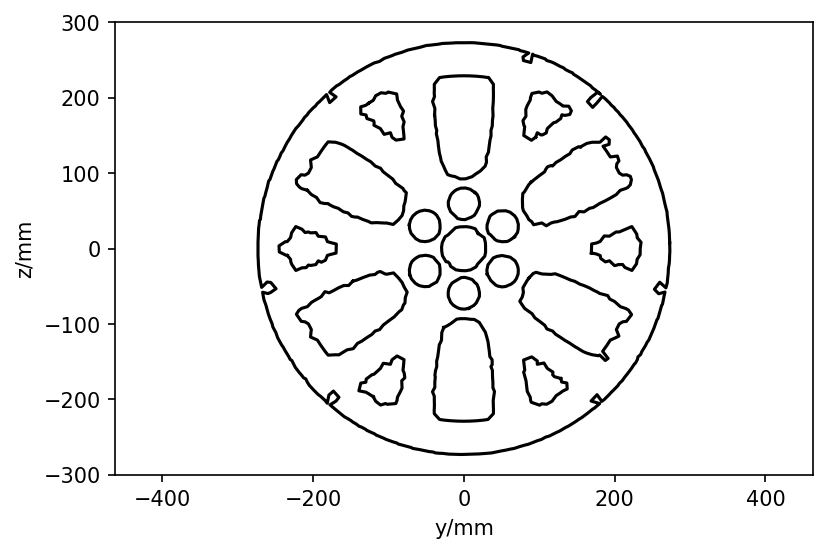

In [6]:
# plot
# tri_color = np.ones(3)*0.5
# plt.triplot(points_yz[:,0],points_yz[:,1],new_tri_set,linewidth = 0.2, color = tri_color)

for i in range(len(final_contour)):
    x = [points_yz[j][0] for j in final_contour[i]]
    y = [points_yz[j][1] for j in final_contour[i]]
    plt.plot(x,y,color = 'k')
plt.axis('equal')
plt.xlabel('y/mm')
plt.ylabel('z/mm')
plt.show()

### Traditional AlphaShape
Note that the time does not include the procedure of changing the lines of boundary into contours which is only a very small portion of the whole time.

In [140]:
# traditional alpha shape
ps = time.time()
boundary = []
for i in range(points_yz.shape[0]-1):
    if i %100 ==0 :
        print(i*100/points_yz.shape[0],'%')
    for j in range(i+1,points_yz.shape[0]):
        if i != j:
            max_l = np.linalg.norm(points_yz[i,:]-points_yz[j,:])
            if max_l < 2*alpha:
                rp = [points_yz[i,:],points_yz[j,:]]
                mid = (rp[0]+rp[1])/2
                slope = rp[0]-rp[1]
                if slope[1] != 0:
                    k = np.array([1,-slope[0]/slope[1]])
                else:
                    k = np.array([0,1])
                d = (alpha**2 - max_l**2/4)**0.5
                c1 = mid - d*k/(np.sum(k**2))**0.5
                c2 = mid + d*k/(np.sum(k**2))**0.5
                flag = 0
                for k in range(points_yz.shape[0]):
                    if k !=i and k != j:
                        sp = points_yz[k,:]
                        if (np.sum((sp - c1)**2))**0.5 < alpha:
                            flag = 1
                            break
                if flag == 1:
                    flag = 0
                    for k in range(points_yz.shape[0]):
                        if k !=i and k != j:
                            sp = points_yz[k,:]
                            if (np.sum((sp - c2)**2))**0.5 < alpha:
                                flag = 1
                                break
                if flag == 0:
                    boundary.append([i,j])
print(time.time()-ps) 

0.0 %
1.644195988161789 %
3.288391976323578 %
4.932587964485367 %
6.576783952647156 %
8.220979940808945 %
9.865175928970734 %
11.509371917132523 %
13.153567905294311 %
14.7977638934561 %
16.44195988161789 %
18.086155869779677 %
19.730351857941468 %
21.374547846103255 %
23.018743834265045 %
24.662939822426832 %
26.307135810588623 %
27.95133179875041 %
29.5955277869122 %
31.23972377507399 %
32.88391976323578 %
34.528115751397564 %
36.172311739559355 %
37.816507727721145 %
39.460703715882936 %
41.10489970404472 %
42.74909569220651 %
44.3932916803683 %
46.03748766853009 %
47.68168365669188 %
49.325879644853664 %
50.970075633015455 %
52.614271621177245 %
54.258467609339036 %
55.90266359750082 %
57.54685958566261 %
59.1910555738244 %
60.83525156198619 %
62.47944755014798 %
64.12364353830976 %
65.76783952647156 %
67.41203551463335 %
69.05623150279513 %
70.70042749095693 %
72.34462347911871 %
73.98881946728049 %
75.63301545544229 %
77.27721144360407 %
78.92140743176587 %
80.56560341992765 %
82

(-300.6187893676758, 301.198293762207, -300.55271339416504, 301.19065539042157)

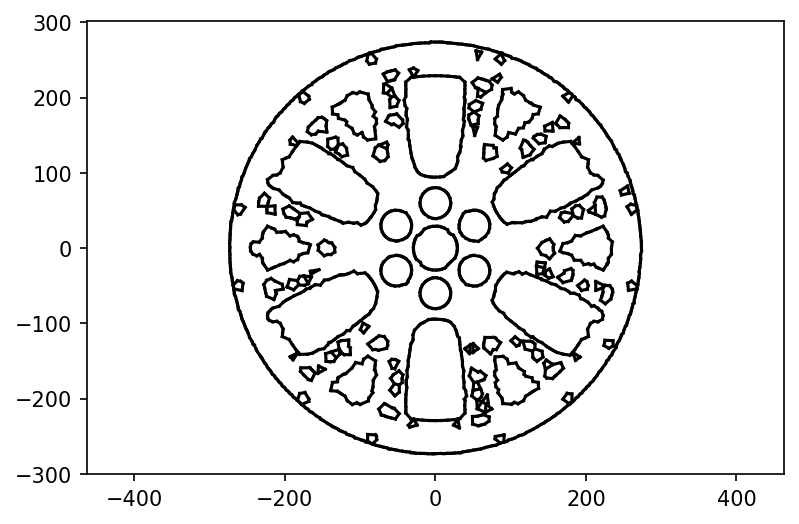

In [100]:
#plot
for i in range(len(boundary)):
    plt.plot([points_yz[boundary[i][0],0],points_yz[boundary[i][1],0]],[points_yz[boundary[i][0],1],points_yz[boundary[i][1],1]],'k')
plt.axis('equal')

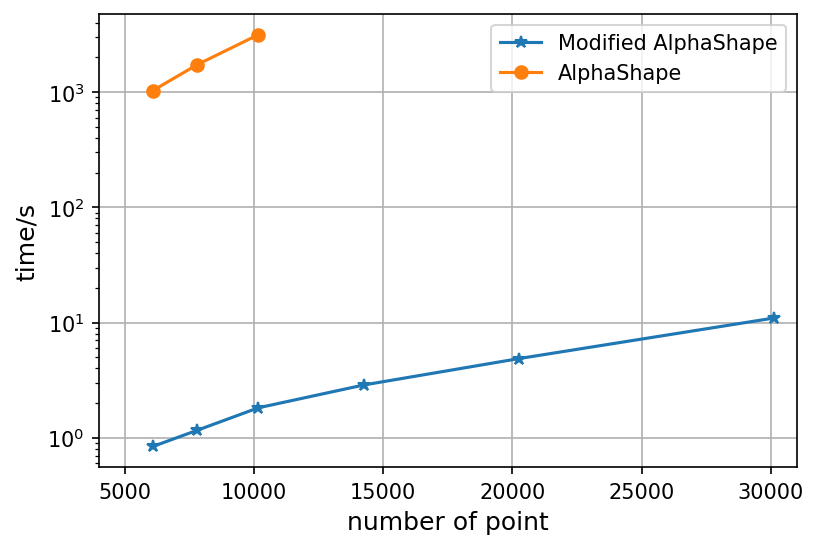

In [162]:
nums = [6082,7795,10168,14247,20270,30118]
new = [0.84,1.16,1.82,2.87,4.87,10.93]
initial = [1028.52,1723.58,3143.61]
plt.axes(yscale = "log")

plt.plot(nums,new,'*-',label = 'Modified AlphaShape')
plt.plot(nums[:3],initial,'o-',label = 'AlphaShape')
plt.legend()
plt.grid()
plt.xlim(4000,31000)
plt.xlabel('number of point',fontsize=12)
plt.ylabel('time/s',fontsize=12)
plt.savefig('AlphaShape.jpg')
plt.show()